# Подгружаем все что может понадобится

In [2]:
import pandas as pd
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
from sortedcontainers import SortedDict
import warnings
import math
from copy import deepcopy
from tqdm import tqdm
import matplotlib as mpl
import platform
from collections import Counter
from IPython.core.display import HTML
import os
from copy import deepcopy
from sklearn.metrics import f1_score
import json
from sklearn.metrics import roc_auc_score
from copy import deepcopy
from catboost import CatBoostClassifier
from statistics import median
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.validation.np_iterators import TimeSeriesIterator
from datetime import timedelta
from lightautoml.utils.profiler import Profiler
p = Profiler()
p.change_deco_settings({'enabled': True})

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
tqdm.pandas()


warnings.filterwarnings('ignore')
pd.options.display.max_rows = 10000




INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
#%pip install --user lightautoml

# Посмотрим на наши данные и почистим их

In [4]:
#fol = pd.read_csv("/Users/a185583357/Downloads/MMzip/fol/LKOH.txt", sep=",")

#TODO Inspect 20150923 - lots of errors there
fol = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog20150310/OrderLog20150310.txt", sep=',')
fol["TRADENO"] = fol["TRADENO"].astype(str)
fol.tail()

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
26214948,26214949,FXIT,S,184457675,12836191,0,2461.0000,11285,nan,NaN
26214949,26214950,OGKB,S,184458220,12805810,0,0.2164,1000,nan,NaN
26214950,26214951,SBER,B,184458269,12819204,0,69.0900,30,nan,NaN
26214951,26214952,VZRZP,S,184458683,6479754,0,91.5000,20,nan,NaN
26214952,26214953,FXGD,S,184459634,12836206,0,519.0000,56500,nan,NaN


In [5]:


count = Counter(fol["SECCODE"]).most_common(30)
out = []
for share in count:
    out.append(share[0])
count

[('GAZP', 2997383),
 ('SBER', 2290044),
 ('SNGS', 2087074),
 ('CHMF', 1425078),
 ('RTKM', 1339749),
 ('LKOH', 1049386),
 ('ROSN', 844480),
 ('SBERP', 738394),
 ('VTBR', 714055),
 ('HYDR', 713783),
 ('SNGSP', 712352),
 ('MGNT', 704247),
 ('TRNFP', 694222),
 ('GMKN', 631399),
 ('NLMK', 593623),
 ('MTSS', 593605),
 ('MTLR', 581235),
 ('MOEX', 551809),
 ('URKA', 468585),
 ('TATN', 459544),
 ('ALRS', 456695),
 ('MAGN', 436832),
 ('EONR', 418226),
 ('FEES', 377768),
 ('AFKS', 366013),
 ('IRAO', 330446),
 ('MVID', 258997),
 ('NVTK', 251434),
 ('OGKB', 191821),
 ('SIBN', 191810)]

In [6]:
fol.head(5)

,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE
0,1,ENRU,B,100000000,1,1,0.785,100000,nan,NaN
1,2,SBERP,B,100000000,2,1,52.400,10000,nan,NaN
2,3,AFKS,B,100000000,3,1,15.880,100,nan,NaN
3,4,AFLT,B,100000000,4,1,37.000,100,nan,NaN
4,5,ALRS,S,100000000,5,1,77.000,20000,nan,NaN


#  Соберем стакан из этого

Общая идея взята из статьи - https://habr.com/ru/post/276635/

In [7]:
from sortedcontainers import SortedDict

class DOM:
    def __init__(self):
        self.bid = SortedDict() #descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.day = None
        self.flag = None
        
    
    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.day = data["DATE"]
        
        if data["ACTION"] == 1:
            self.check_add(data)
        elif data["ACTION"] == 0:
            self.delete_order(data)
        else:
            self.trade(data)
        
    ## First part - adding order
        
    def check_add(self, data):
        if data["PRICE"] < 0.000000001:
            self.add_order(data)
            pass
        else:
            self.add_order(data)
                
    
    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
    ## Second part - delete order
    
    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]
    
    ## Third part - match order   
    def trade(self, data):
        if data['BUYSELL'] == "B":
            self.exec_buy_order(data)
        else:
            self.exec_sell_order(data)
    

    def exec_sell_order(self, data):
        self.flag = None
        order = self.ask_active_order[data["ORDERNO"]]
        if data["VOLUME"] < order[1]:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], 
                                                      order[1] - data["VOLUME"])
        elif data["VOLUME"] == order[1]:
            del self.ask_active_order[data["ORDERNO"]]
        else:
            #iseberg or error
            #raise Exception(self.ask_active_order[data["ORDERNO"]], data)
            del self.ask_active_order[data["ORDERNO"]]
            self.flag = data["ORDERNO"]
            
        
        if data["PRICE"] not in self.ask:
            raise Exception
            pass
        else:
            self.ask[data["PRICE"]] -= min(order[1], data["VOLUME"])
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    
    
    def exec_buy_order(self, data):
        self.flag = None
        order = self.bid_active_order[data["ORDERNO"]]
        if data["VOLUME"] < order[1]:
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], 
                                                      order[1] - data["VOLUME"])
        elif data["VOLUME"] == order[1]:
            del self.bid_active_order[data["ORDERNO"]]
        else:
            #iseberg or error
            #raise Exception(self.bid_active_order[data["ORDERNO"]], data)
            del self.bid_active_order[data["ORDERNO"]]
            flag = data["ORDERNO"]
        
        if data["PRICE"] not in self.bid:
            raise Exception(data, self.bid)
            pass
        else:
            self.bid[data["PRICE"]] -= min(order[1], data["VOLUME"])
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
    
    ## Others
    
        
    def clean_dom(self):
        self.__init__()
        
        

In [8]:
date = "20150310"
data = fol[fol["SECCODE"] == "SBER"]
data = data[data["ACTION"] != 2]
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(2115840, 12)

In [9]:
dom = DOM()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

100%|██████████| 2115840/2115840 [00:05<00:00, 358478.11it/s]


# Создадим стакан способный сам матчить все заявки и сравним с оригиналом

In [10]:
date = "20150310"
data = fol[fol["SECCODE"] == "SBER"]
data = data[data["ACTION"] != 2]
data["DATE"] = date
records = data.to_dict("records")
data.reset_index(inplace=True)
data.shape

(2115840, 12)

In [11]:
data.head()

,index,NO,SECCODE,BUYSELL,TIME,ORDERNO,ACTION,PRICE,VOLUME,TRADENO,TRADEPRICE,DATE
0,47,48,SBER,B,100000000,48,1,70.00,20,nan,NaN,20150310
1,49,50,SBER,B,100000000,50,1,70.50,880,nan,NaN,20150310
2,94,95,SBER,B,100000000,95,1,72.45,15000,nan,NaN,20150310
3,138,139,SBER,B,100000000,139,1,72.23,10700,nan,NaN,20150310
4,147,148,SBER,B,100000000,148,1,71.00,100,nan,NaN,20150310


In [12]:
class Matching_Engine:
    def __init__(self):
        self.bid = SortedDict()  # descending
        self.ask = SortedDict()
        self.bid_active_order = dict()
        self.ask_active_order = dict()
        self.bid_FIFO = dict()
        self.ask_FIFO = dict()
        self.day = None
        self.share_name = "LKOH"
        self.trade_log = []

    def check_order(self, data):
        if self.day != data["DATE"]:
            self.clean_dom()
            self.share_name = data["SECCODE"]
            self.day = data["DATE"]

        if data["ACTION"] == 1:
            return self.check_add(data, new_trades=[])
        elif data["ACTION"] == 2:
            pass
        else:
            self.delete_order(data)

    ## First part - adding order

    def check_add(self, data, rec_flag=False, new_trades=[]):
        if (len(self.ask) > 0 and data['BUYSELL'] == "B" and \
            (data["PRICE"] >= self.ask.peekitem(0)[0] or data["PRICE"] < 0.000001)) or \
                (len(self.bid) > 0 and data['BUYSELL'] == "S" and data["PRICE"] <= self.bid.peekitem(-1)[0]):
            if not rec_flag:
                self.add_order(data)
            return self.trade(data, new_trades=new_trades)
        else:
            if not rec_flag:
                self.add_order(data)

    def add_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.bid:
                self.bid[data["PRICE"]] = data["VOLUME"]
                self.bid_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.bid[data["PRICE"]] += data["VOLUME"]
                self.bid_FIFO[data["PRICE"]].append(data["ORDERNO"])
        else:
            self.ask_active_order[data["ORDERNO"]] = (data["PRICE"], data["VOLUME"])
            if data["PRICE"] not in self.ask:
                self.ask[data["PRICE"]] = data["VOLUME"]
                self.ask_FIFO[data["PRICE"]] = [data["ORDERNO"]]
            else:
                self.ask[data["PRICE"]] += data["VOLUME"]
                self.ask_FIFO[data["PRICE"]].append(data["ORDERNO"])

    ## Second part - delete order

    def delete_order(self, data):
        if data['BUYSELL'] == "B":
            self.bid_FIFO[data["PRICE"]].pop(self.bid_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            self.bid[data["PRICE"]] -= self.bid_active_order[data["ORDERNO"]][1]
            if len(self.bid_FIFO[data["PRICE"]]) < 1:
                del self.bid_FIFO[data["PRICE"]]
            del self.bid_active_order[data["ORDERNO"]]
            if self.bid[data["PRICE"]] < 0.000000001:
                del self.bid[data["PRICE"]]
        else:
            self.ask[data["PRICE"]] -= self.ask_active_order[data["ORDERNO"]][1]
            self.ask_FIFO[data["PRICE"]].pop(self.ask_FIFO[data["PRICE"]].index(data["ORDERNO"]))
            if len(self.ask_FIFO[data["PRICE"]]) < 1:
                del self.ask_FIFO[data["PRICE"]]
            del self.ask_active_order[data["ORDERNO"]]
            if self.ask[data["PRICE"]] < 0.000000001:
                del self.ask[data["PRICE"]]

    ## Third part - match order
    def trade(self, data, new_trades=[]):
        if data['BUYSELL'] == "B":
            return self.exec_buy_order(data, new_trades=new_trades)
        else:
            return self.exec_sell_order(data, new_trades=new_trades)

    def exec_sell_order(self, data, new_trades=[]):
        go_trade= True
        while go_trade:
            go_trade = False
            sell_order = self.ask_active_order[data["ORDERNO"]]
            tradeprice = self.bid.peekitem(-1)[0]
            order_no = self.bid_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            buy_order = self.bid_active_order[order_no]
            if buy_order[1] > sell_order[1]:
                self.bid_active_order[order_no] = (self.bid_active_order[order_no][0],
                                                   buy_order[1] - sell_order[1])
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "B"

                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no

                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "B"
                tmp["PRICE"] = buy_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0],
                                                          sell_order[1] - buy_order[1])
                # TODO не учтено полное пробитие стакана!!
                if self.bid.peekitem(-1)[0] >= sell_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "S"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.ask_active_order[data["ORDERNO"]] = (self.ask_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.ask[data["PRICE"]] -= data["VOLUME"]
                #return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    def exec_buy_order(self, data, new_trades=[]):
        go_trade = True
        while go_trade:
            go_trade = False
            buy_order = self.bid_active_order[data["ORDERNO"]]
            tradeprice = self.ask.peekitem(0)[0]
            order_no = self.ask_FIFO[tradeprice][0]
            if str(order_no)[0] == 'm':
                out_no = "mm_past"
            else:
                out_no = order_no
            sell_order = self.ask_active_order[order_no]
            if sell_order[1] > buy_order[1]:
                self.ask_active_order[order_no] = (self.ask_active_order[order_no][0],
                                                   sell_order[1] - buy_order[1])
                trade_vol = buy_order[1]
                self.ask[sell_order[0]] -= trade_vol
                self.delete_order(data)
            elif buy_order[1] == sell_order[1]:
                self.delete_order(data)
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = self.ask_FIFO[tradeprice][0]
                self.delete_order(tmp)
                trade_vol = sell_order[1]
            else:
                # iseberg or error
                tmp = dict()
                tmp["BUYSELL"] = "S"
                tmp["PRICE"] = sell_order[0]
                tmp["ORDERNO"] = order_no
                self.delete_order(tmp)
                trade_vol = sell_order[1]
                self.bid[buy_order[0]] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0],
                                                          buy_order[1] - sell_order[1])
                if self.ask.peekitem(0)[0] <= buy_order[0] or data["PRICE"] < 0.000000001:
                    go_trade = True

            # TODO Мне кажется здесь потенциальная ошибка, не предусмотрено что аркет мейкер заявка может в кого то удариться
            self.trade_log.append(
                [tradeprice, trade_vol, data["ORDERNO"], out_no, tradeprice * trade_vol, data["TIME"], data["NO"], "B"])
            new_trades.append(self.trade_log[-1])
            if buy_order[1] < 0 or sell_order[1] < 0:
                raise Exception(buy_order, sell_order)
            if go_trade:
                data["VOLUME"] -= trade_vol
                self.bid_active_order[data["ORDERNO"]] = (self.bid_active_order[data["ORDERNO"]][0], data["VOLUME"])
                # self.bid[data["PRICE"]] -= data["VOLUME"]
                return self.check_add(data, rec_flag=True, new_trades=new_trades)
        return new_trades

    ## Others

    def clean_dom(self):
        self.__init__()



In [13]:
dom = Matching_Engine()
errors = 0
isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]

for i in tqdm(range(len(records))):
    record = records[i].copy()
    if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
        record["VOLUME"] = isebergs[record["ORDERNO"]]
    try:
        out = dom.check_order(record)
    except Exception as e:
        #print(e)
        if record["ACTION"] == 1:
            print("MAYBE Some problem, cant add order")
            dom.check_order(record)
            raise Exception
        errors += 1

100%|██████████| 2115840/2115840 [00:10<00:00, 197774.01it/s]


In [14]:
dom.trade_log[-1]

[69.97, 100, 12836092, 12836086, 6997.0, 183958906, 26213007, 'B']

# Теперь сделаем заготовку для ML, для этого соберем numpy array снапшота стакана и последих трейдов

In [15]:
deep = 1

In [16]:
def RSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = deepcopy(0 * diff)
    down_chg = deepcopy(0 * diff)
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
   
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    
    up_chg_avg   = up_chg.mean()
    down_chg_avg = down_chg.mean()
    
    if down_chg_avg == 0:
        return 100.0
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [17]:
def VWAP(trade_log, record, vwap, top_price, min_price, timerange=1):
    timenow = datetime.datetime.strptime(str(record["TIME"]), '%H%M%S%f')
    time_log = pd.to_datetime(pd.Series(np.array(trade_log)[:, -3]), format='%H%M%S%f')
    trades_window = np.array(trade_log)[time_log > (timenow - datetime.timedelta(seconds=timerange))]
    if trades_window.shape[0] == 0:
        return vwap, top_price, min_price
    else:
        return sum(trades_window[:, 0].astype(float) * trades_window[:, 1].astype(int)) /  sum(trades_window[:, 1].astype(int)), max(trades_window[:, 0].astype(float)), min(trades_window[:, 0].astype(float))

In [18]:
tmp = datetime.datetime.strptime(str(record["TIME"]), '%H%M%S%f')
time_log = pd.to_datetime(pd.Series(np.array(dom.trade_log)[:, -3]), format='%H%M%S%f')
tmp = np.array(dom.trade_log)[time_log > (tmp - datetime.timedelta(seconds=500))]
max(tmp[:, 0].astype(float))

69.98

In [19]:
sma5, sma10, sma30, sma50, sma100 = 0, 0, 0, 0, 0
ema5, ema10, ema30, ema100 = 0, 0, 0, 0
std10, std50, std100, std1000 = 0, 0, 0, 0
rsi14, rsi50, rsi100, rsi300 = 0, 0, 0, 0
vwap1, vwap30, vwap60 = 0, 0, 0
top_price1, top_price30, top_price60 = 0, 0, 0
min_price1, min_price30, min_price60 = 0, 0, 0

def get_technical_indicator(change, trade_log, output, record):
    #TODO это однозначно можно сделать оптимальнее!!
    global deep
    global sma5, sma10, sma30, sma50, sma100
    global ema5, ema10, ema30, ema100
    global std10, std50, std100, std1000 
    global rsi14, rsi50, rsi100, rsi300
    global vwap1, vwap30, vwap60
    global top_price1, top_price30, top_price60
    global min_price1, min_price30, min_price60
    if change != 0:        
        sma5 = np.array(trade_log[-5:])[:, 0].astype(float).mean()
        sma10 = np.array(trade_log[-10:])[:, 0].astype(float).mean()
        sma30 = np.array(trade_log[-30:])[:, 0].astype(float).mean()
        sma50 = np.array(trade_log[-50:])[:, 0].astype(float).mean()
        sma100 = np.array(trade_log[-100:])[:, 0].astype(float).mean()
        #EMA
        ema5 = pd.DataFrame(np.array(trade_log[-5:])[:, 0].astype(float)).ewm(span=5).mean().iat[-1, 0]
        ema10 = pd.DataFrame(np.array(trade_log[-10:])[:, 0].astype(float)).ewm(span=10).mean().iat[-1, 0]
        ema30 = pd.DataFrame(np.array(trade_log[-30:])[:, 0].astype(float)).ewm(span=30).mean().iat[-1, 0]
        ema100 = pd.DataFrame(np.array(trade_log[-100:])[:, 0].astype(float)).ewm(span=30).mean().iat[-1, 0]
        #std
        std10 = np.array(trade_log[-10:])[:, 0].astype(float).std()
        std50 = np.array(trade_log[-50:])[:, 0].astype(float).std()
        std100 = np.array(trade_log[-100:])[:, 0].astype(float).std()
        std1000 = np.array(trade_log[-1000:])[:, 0].astype(float).std()
        #RSI
        rsi14 = RSI(pd.Series(np.array(trade_log[-14:])[:, 0].astype(float)), 14)
        rsi50 = RSI(pd.Series(np.array(trade_log[-50:])[:, 0].astype(float)), 50)
        rsi100 = RSI(pd.Series(np.array(trade_log[-100:])[:, 0].astype(float)), 100)
        rsi300 = RSI(pd.Series(np.array(trade_log[-300:])[:, 0].astype(float)), 300)
        #VWAP, top, min
        vwap1, top_price1, min_price1 = VWAP(trade_log[-1000:], record, vwap1, top_price1, min_price1, timerange=1)
        vwap30, top_price30, min_price30 = VWAP(trade_log[-3000:], record, vwap30, top_price30, min_price60, timerange=30)
        vwap60, top_price60, min_price60 = VWAP(trade_log[-5000:], record, vwap60, top_price30, min_price60, timerange=60)
    output[deep * 4 + 7] = sma5
    output[deep * 4 + 8] = sma10
    output[deep * 4 + 9] = sma30
    output[deep * 4 + 10] = sma50
    output[deep * 4 + 11] = sma100
    #EMA
    output[deep * 4 + 12] = ema5
    output[deep * 4 + 13] = ema10
    output[deep * 4 + 14] = ema30
    output[deep * 4 + 15] = ema100
    #std
    output[deep * 4 + 16] = std10
    output[deep * 4 + 17] = std50
    output[deep * 4 + 18] = std100
    output[deep * 4 + 19] = std1000
    #RSI
    output[deep * 4 + 20] = rsi14
    output[deep * 4 + 21] = rsi50
    output[deep * 4 + 22] = rsi100
    output[deep * 4 + 23] = rsi300
    #VWAP
    output[deep * 4 + 24] = vwap1
    output[deep * 4 + 25] = vwap30
    output[deep * 4 + 26] = vwap60
    #top
    output[deep * 4 + 27] = top_price1
    output[deep * 4 + 28] = top_price30
    output[deep * 4 + 29] = top_price60
    #min
    output[deep * 4 + 30] = min_price1
    output[deep * 4 + 31] = min_price30
    output[deep * 4 + 32] = min_price60
    return output

In [20]:
def construct_raw(dom, deep, raw_data, record):
    output = [0] * (deep * 4 + 33)
    trade_log = dom.trade_log
    bids = list(dom.bid.items())
    asks = list(dom.ask.items())
    for i in range(0, deep):
        if len(bids) > i:
            #print(bids[-1], i)
            output[(2 * deep) - 2 * i - 1] = bids[-i - 1][1]
            output[(2 * deep) - 2 * i - 2] = bids[-i - 1][0]
        if len(asks) > i:
            #print(asks, i)
            output[(2 * deep) + 2 * i + 1] = asks[i][1]
            output[(2 * deep) + 2 * i] = asks[i][0]
    if len(dom.trade_log) > 0:
        #print(dom.trade_log[-1])
        output[deep * 4] = dom.trade_log[-1][0]
        output[deep * 4 + 1] = dom.trade_log[-1][1]
        if output[deep * 4 + 2] == "B":
            output[deep * 4 + 2] = -1
        else:
            output[deep * 4 + 2] = 1
        change = raw_data[-1][deep * 4] - output[deep * 4]
        if change == 0:
            output[deep * 4 + 3] = 0
        elif change > 0:
            output[deep * 4 + 3] = -1
        else:
            output[deep * 4 + 3] = 1
            
        output[deep * 4 + 4] = dom.trade_log[-1][-3]
    output[deep * 4 + 5] = int(record["DATE"])
    output[deep * 4 + 6] = record["TIME"]
    if len(trade_log) > 50:
        output = get_technical_indicator(change, trade_log, output, record)
    
    
    return output

In [21]:
def get_data(date, records, deep):
    dom = Matching_Engine()
    errors = 0
    isebergs = pd.read_csv("/Users/a185583357/Desktop/MOEX/OrderLog" + date + "/isebergs" + date + ".csv", index_col=0).to_dict()["vol"]
    raw_data = []

    for i in tqdm(range(len(records))):
        record = records[i].copy()
        if record["ACTION"] == 1 and record["ORDERNO"] in isebergs:
            record["VOLUME"] = isebergs[record["ORDERNO"]]
        try:
            out = dom.check_order(record)
            raw_data.append(construct_raw(dom, deep, raw_data, record))
        except Exception as e:
            #print(e)
            if record["ACTION"] == 1:
                print("MAYBE Some problem, cant add order")
                dom.check_order(record)
                raise Exception
            errors += 1
    return raw_data


raw_data = get_data(date, records, deep)
#raw_data[1000]

100%|██████████| 2115840/2115840 [41:31<00:00, 849.19it/s]  


In [22]:
def find_nearest(raw, future1, future30, future60):
    dt = raw.Time
    nearest1 = future1.iloc[future1.index.get_loc(dt, method='nearest')]
    nearest30 = future30.iloc[future30.index.get_loc(dt, method='nearest')]
    nearest60 = future60.iloc[future60.index.get_loc(dt, method='nearest')]
    raw["FutureVWAP1"] = nearest1["FutureVWAP1"]
    raw["MIN1"] = nearest1["MIN1"]
    raw["TOP1"] = nearest1["TOP1"]    
    raw["FutureVWAP30"] = nearest30["FutureVWAP30"]
    raw["MIN30"] = nearest30["MIN30"]
    raw["TOP30"] = nearest30["TOP30"]
    raw["FutureVWAP60"] = nearest60["FutureVWAP60"]
    raw["MIN60"] = nearest60["MIN60"]
    raw["TOP60"] = nearest60["TOP60"]
    return raw
    


def create_future_vwap(snapchot):
    snapchot["FutureVWAP1"] = deepcopy(snapchot["VWAP1"])
    snapchot["FutureVWAP30"] = deepcopy(snapchot["VWAP30"])
    snapchot["FutureVWAP60"] = deepcopy(snapchot["VWAP60"])
    future1 = deepcopy(snapchot.shift(freq=-timedelta(seconds=1)))
    future30 = deepcopy(snapchot.shift(freq=-timedelta(seconds=30)))
    future60 = deepcopy(snapchot.shift(freq=-timedelta(seconds=60)))
    try:
        snapchot = snapchot.parallel_apply(find_nearest, args=(future1, future30, future60), axis=1)
    except:
        snapchot = snapchot.progress_apply(find_nearest, args=(future1, future30, future60), axis=1)
    snapchot["Difference1"] = snapchot["FutureVWAP1"] - snapchot["VWAP1"]
    snapchot["Difference30"] = snapchot["FutureVWAP30"] - snapchot["VWAP30"]
    snapchot["Difference60"] = snapchot["FutureVWAP60"] - snapchot["VWAP60"]
    snapchot["IsUp1"] = np.sign(snapchot["Difference1"])
    snapchot["IsUp30"] = np.sign(snapchot["Difference30"])
    snapchot["IsUp60"] = np.sign(snapchot["Difference60"])
    return snapchot
    

In [23]:
snapschot = pd.read_csv("SBER20150310.csv")

In [24]:
def get_df_y(raw_data, deep):
    columns = []
    for col in ["Bid", "Ask"]:
        for num in range(1, 1 + deep):
            if col == "Bid":
                num = deep - num + 1
            columns.append(col + "Price" + str(num))
            columns.append(col + "Volume" + str(num))
    dupl_col = deepcopy(columns)
    columns += ["Last Trade Price"] + ["Last Trade Volume"] + ["Side"] + ["isNewTrade"] + \
    ["LastDealTime"] + ["Date"] + ["Time"] + ["SMA5"] + ["SMA10"] + ["SMA30"] + ["SMA50"] + ["SMA100"] +\
    ["EMA5"] + ["EMA10"] + ["EMA30"] + ["EMA100"] + ["STD10"] + ["STD50"] + ["STD100"] + ["STD1000"] +\
    ["RSI14"] + ["RSI50"] + ["RSI100"] + ["RSI300"] + ["VWAP1"] + ["VWAP30"] + ["VWAP60"] +\
    ["TOP1"] + ["TOP30"] + ["TOP60"] + ["MIN1"] + ["MIN30"] + ["MIN60"] 
    snapschot = pd.DataFrame(np.stack(raw_data, axis=0), columns=columns)
    snapschot["LiquidityBid"] = 0
    snapschot["LiquidityAsk"] = 0
    for i in range(1, 1 + deep):
        snapschot['LiquidityAsk'] += snapschot["AskVolume" + str(i)]
        snapschot["LiquidityBid"] += snapschot["BidVolume" + str(i)]

    snapschot["BidLiquidityRatio"] = snapschot["LiquidityBid"] / (snapschot["LiquidityBid"] + snapschot["LiquidityAsk"])
    snapschot = snapschot[snapschot["Time"] > 100002000.0]
    snapschot.drop_duplicates(subset=dupl_col,inplace=True)
    
    snapschot.index = snapschot["Time"]
    snapschot = snapschot[~snapschot.index.duplicated(keep='last')]
    tmp_time = deepcopy(snapschot.index)
    snapschot["Time"] = pd.to_datetime((snapschot["Time"]), format='%H%M%S%f')
    snapschot.index = snapschot["Time"]
    snapschot = create_future_vwap(snapschot)
    snapschot["Time"] = tmp_time
    y = np.array(snapschot["IsUp60"])
    drop_col = ["IsUp1", "IsUp30", "IsUp60", "Difference1", "Difference30", "Difference60",
                "FutureVWAP1", "FutureVWAP30", "FutureVWAP60"]
    df = snapschot.drop(drop_col, axis=1)
    return df, np.array(y), snapschot

df, y, snapschot = get_df_y(raw_data, deep)
snapschot.to_csv("SBER20150310.csv")

## Attention надо обязательно сделать задержку и смещение

Данные готовы, по одному дню сбера. теперь посмотрим на них

## Здесь будут графики и анализ существующих данных

In [25]:
snapschot[30000:30005]

,BidPrice1,BidVolume1,AskPrice1,AskVolume1,Last Trade Price,Last Trade Volume,Side,isNewTrade,LastDealTime,Date,...,BidLiquidityRatio,FutureVWAP1,FutureVWAP30,FutureVWAP60,Difference1,Difference30,Difference60,IsUp1,IsUp30,IsUp60
Time,,,,,,,,,,,,,,,,,,,,,
1900-01-01 11:58:22.564,71.32,1000.0,71.33,13580.0,71.32,10.0,1.0,0.0,115820673.0,20150310.0,...,0.068587,71.33,71.370617,71.365315,0.000455,0.051205,0.033244,1.0,1.0,1.0
1900-01-01 11:58:22.789,71.32,1010.0,71.33,13580.0,71.32,10.0,1.0,0.0,115820673.0,20150310.0,...,0.069225,71.33,71.371935,71.365315,0.000455,0.052524,0.033244,1.0,1.0,1.0
1900-01-01 11:58:22.830,71.32,1040.0,71.33,13580.0,71.32,10.0,1.0,0.0,115820673.0,20150310.0,...,0.071135,71.33,71.371935,71.365315,0.000455,0.052524,0.033244,1.0,1.0,1.0
1900-01-01 11:58:23.351,71.32,1040.0,71.33,9480.0,71.33,2700.0,1.0,0.0,115823351.0,20150310.0,...,0.098859,71.33,71.371935,71.365315,0.000000,0.054793,0.033840,0.0,1.0,1.0
1900-01-01 11:58:23.434,71.32,1040.0,71.33,12990.0,71.33,2700.0,1.0,0.0,115823351.0,20150310.0,...,0.074127,71.33,71.371935,71.365315,0.000000,0.054793,0.033840,0.0,1.0,1.0


In [26]:
visu_data = snapschot#[1500:]

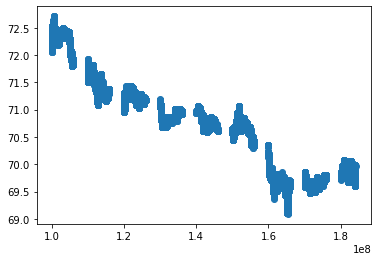

In [27]:
plt.scatter(visu_data["Time"], visu_data["Last Trade Price"])

In [28]:
pd.to_datetime((snapschot["Time"]), format='%H%M%S%f')

Time
1900-01-01 10:00:02.019   1900-01-01 10:00:02.019
1900-01-01 10:00:02.115   1900-01-01 10:00:02.115
1900-01-01 10:00:02.128   1900-01-01 10:00:02.128
1900-01-01 10:00:02.134   1900-01-01 10:00:02.134
1900-01-01 10:00:02.140   1900-01-01 10:00:02.140
                                    ...          
1900-01-01 18:39:58.806   1900-01-01 18:39:58.806
1900-01-01 18:39:58.807   1900-01-01 18:39:58.807
1900-01-01 18:39:58.893   1900-01-01 18:39:58.893
1900-01-01 18:39:58.906   1900-01-01 18:39:58.906
1900-01-01 18:43:05.630   1900-01-01 18:43:05.630
Name: Time, Length: 107001, dtype: datetime64[ns]

## Тут Random forest

In [29]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(3) 
for train_index, test_index in tscv.split(df):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.array(df)[train_index], np.array(df)[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [    0     1     2 ... 26748 26749 26750] TEST: [26751 26752 26753 ... 53498 53499 53500]
TRAIN: [    0     1     2 ... 53498 53499 53500] TEST: [53501 53502 53503 ... 80248 80249 80250]
TRAIN: [    0     1     2 ... 80248 80249 80250] TEST: [ 80251  80252  80253 ... 106998 106999 107000]


In [30]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [31]:
Counter(rf.predict(X_test)), f1_score(y_test, rf.predict(X_test), average='micro')

(Counter({-1.0: 9480, 1.0: 17270}), 0.5309906542056074)

Feature ranking:
1. feature BidPrice1 (0.095936)
2. feature BidVolume1 (0.073310)
3. feature AskPrice1 (0.070551)
4. feature AskVolume1 (0.067793)
5. feature Last Trade Price (0.067118)
6. feature Last Trade Volume (0.061318)
7. feature Side (0.053430)
8. feature isNewTrade (0.047009)
9. feature LastDealTime (0.038753)
10. feature Date (0.037950)
11. feature Time (0.036661)
12. feature SMA5 (0.033978)
13. feature SMA10 (0.033327)
14. feature SMA30 (0.025639)
15. feature SMA50 (0.025626)
16. feature SMA100 (0.021074)
17. feature EMA5 (0.019651)
18. feature EMA10 (0.019524)
19. feature EMA30 (0.018313)
20. feature EMA100 (0.014770)
21. feature STD10 (0.014297)
22. feature STD50 (0.014187)
23. feature STD100 (0.013892)
24. feature STD1000 (0.012372)
25. feature RSI14 (0.011778)
26. feature RSI50 (0.009859)
27. feature RSI100 (0.008754)
28. feature RSI300 (0.008438)
29. feature VWAP1 (0.007861)
30. feature VWAP30 (0.007490)
31. feature VWAP60 (0.007477)
32. feature TOP1 (0.004837)
33. feat

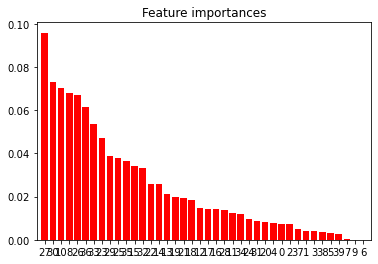

In [34]:
def get_importance(model, importance):    
    indices = np.argsort(importance)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %s (%f)" % (f + 1, df.columns[f], importance[indices[f]]))
    plt.figure()
    plt.title("Feature importances")
    plt.bar(df.columns[indices], importance[indices],
            color="r", align="center")
    plt.xticks(df.columns[indices], indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    

get_importance(rf, rf.feature_importances_)

## Тут Catboost

In [35]:
cbst = CatBoostClassifier()
cbst.fit(pd.DataFrame(X_train), y_train)


Learning rate set to 0.067009
0:	learn: 0.6729231	total: 83.1ms	remaining: 1m 23s
1:	learn: 0.6527200	total: 111ms	remaining: 55.2s
2:	learn: 0.6374813	total: 132ms	remaining: 43.9s
3:	learn: 0.6239375	total: 148ms	remaining: 36.8s
4:	learn: 0.6117097	total: 174ms	remaining: 34.5s
5:	learn: 0.5987890	total: 191ms	remaining: 31.6s
6:	learn: 0.5854561	total: 218ms	remaining: 31s
7:	learn: 0.5749707	total: 248ms	remaining: 30.7s
8:	learn: 0.5670047	total: 276ms	remaining: 30.3s
9:	learn: 0.5581412	total: 301ms	remaining: 29.8s
10:	learn: 0.5510244	total: 326ms	remaining: 29.3s
11:	learn: 0.5438446	total: 349ms	remaining: 28.7s
12:	learn: 0.5359432	total: 367ms	remaining: 27.8s
13:	learn: 0.5308155	total: 386ms	remaining: 27.2s
14:	learn: 0.5208739	total: 411ms	remaining: 27s
15:	learn: 0.5126846	total: 433ms	remaining: 26.6s
16:	learn: 0.5061751	total: 461ms	remaining: 26.6s
17:	learn: 0.5007359	total: 486ms	remaining: 26.5s
18:	learn: 0.4947879	total: 509ms	remaining: 26.3s
19:	learn: 0.

168:	learn: 0.1566466	total: 3.31s	remaining: 16.3s
169:	learn: 0.1563551	total: 3.34s	remaining: 16.3s
170:	learn: 0.1555658	total: 3.36s	remaining: 16.3s
171:	learn: 0.1547133	total: 3.38s	remaining: 16.2s
172:	learn: 0.1536027	total: 3.39s	remaining: 16.2s
173:	learn: 0.1520392	total: 3.4s	remaining: 16.2s
174:	learn: 0.1506577	total: 3.42s	remaining: 16.1s
175:	learn: 0.1492711	total: 3.43s	remaining: 16.1s
176:	learn: 0.1486171	total: 3.44s	remaining: 16s
177:	learn: 0.1473034	total: 3.46s	remaining: 16s
178:	learn: 0.1465891	total: 3.47s	remaining: 15.9s
179:	learn: 0.1460946	total: 3.48s	remaining: 15.9s
180:	learn: 0.1455729	total: 3.49s	remaining: 15.8s
181:	learn: 0.1446287	total: 3.52s	remaining: 15.8s
182:	learn: 0.1441028	total: 3.54s	remaining: 15.8s
183:	learn: 0.1433960	total: 3.55s	remaining: 15.8s
184:	learn: 0.1431079	total: 3.56s	remaining: 15.7s
185:	learn: 0.1427868	total: 3.58s	remaining: 15.7s
186:	learn: 0.1423506	total: 3.59s	remaining: 15.6s
187:	learn: 0.141

341:	learn: 0.0724263	total: 5.99s	remaining: 11.5s
342:	learn: 0.0720248	total: 6.01s	remaining: 11.5s
343:	learn: 0.0715494	total: 6.04s	remaining: 11.5s
344:	learn: 0.0710894	total: 6.05s	remaining: 11.5s
345:	learn: 0.0706976	total: 6.07s	remaining: 11.5s
346:	learn: 0.0703491	total: 6.08s	remaining: 11.4s
347:	learn: 0.0699888	total: 6.09s	remaining: 11.4s
348:	learn: 0.0698233	total: 6.11s	remaining: 11.4s
349:	learn: 0.0696522	total: 6.12s	remaining: 11.4s
350:	learn: 0.0695550	total: 6.13s	remaining: 11.3s
351:	learn: 0.0693472	total: 6.15s	remaining: 11.3s
352:	learn: 0.0689439	total: 6.16s	remaining: 11.3s
353:	learn: 0.0687349	total: 6.17s	remaining: 11.3s
354:	learn: 0.0685377	total: 6.19s	remaining: 11.2s
355:	learn: 0.0682848	total: 6.21s	remaining: 11.2s
356:	learn: 0.0680714	total: 6.22s	remaining: 11.2s
357:	learn: 0.0677761	total: 6.24s	remaining: 11.2s
358:	learn: 0.0674917	total: 6.25s	remaining: 11.2s
359:	learn: 0.0672295	total: 6.26s	remaining: 11.1s
360:	learn: 

501:	learn: 0.0437545	total: 8.3s	remaining: 8.23s
502:	learn: 0.0435856	total: 8.32s	remaining: 8.22s
503:	learn: 0.0434794	total: 8.34s	remaining: 8.21s
504:	learn: 0.0433091	total: 8.36s	remaining: 8.19s
505:	learn: 0.0432110	total: 8.37s	remaining: 8.17s
506:	learn: 0.0429781	total: 8.39s	remaining: 8.16s
507:	learn: 0.0428326	total: 8.4s	remaining: 8.14s
508:	learn: 0.0427158	total: 8.42s	remaining: 8.12s
509:	learn: 0.0426576	total: 8.43s	remaining: 8.1s
510:	learn: 0.0425597	total: 8.45s	remaining: 8.08s
511:	learn: 0.0423194	total: 8.46s	remaining: 8.07s
512:	learn: 0.0421482	total: 8.48s	remaining: 8.05s
513:	learn: 0.0419982	total: 8.5s	remaining: 8.03s
514:	learn: 0.0418356	total: 8.52s	remaining: 8.02s
515:	learn: 0.0417527	total: 8.53s	remaining: 8s
516:	learn: 0.0416627	total: 8.54s	remaining: 7.98s
517:	learn: 0.0416205	total: 8.55s	remaining: 7.96s
518:	learn: 0.0415884	total: 8.57s	remaining: 7.94s
519:	learn: 0.0414917	total: 8.58s	remaining: 7.92s
520:	learn: 0.04139

661:	learn: 0.0293137	total: 10.6s	remaining: 5.39s
662:	learn: 0.0292106	total: 10.6s	remaining: 5.38s
663:	learn: 0.0291781	total: 10.6s	remaining: 5.36s
664:	learn: 0.0291276	total: 10.6s	remaining: 5.34s
665:	learn: 0.0290692	total: 10.6s	remaining: 5.33s
666:	learn: 0.0290542	total: 10.6s	remaining: 5.31s
667:	learn: 0.0290066	total: 10.6s	remaining: 5.29s
668:	learn: 0.0289797	total: 10.7s	remaining: 5.27s
669:	learn: 0.0289351	total: 10.7s	remaining: 5.26s
670:	learn: 0.0288981	total: 10.7s	remaining: 5.24s
671:	learn: 0.0288451	total: 10.7s	remaining: 5.22s
672:	learn: 0.0287879	total: 10.7s	remaining: 5.21s
673:	learn: 0.0287712	total: 10.7s	remaining: 5.19s
674:	learn: 0.0286927	total: 10.7s	remaining: 5.17s
675:	learn: 0.0286520	total: 10.8s	remaining: 5.16s
676:	learn: 0.0285547	total: 10.8s	remaining: 5.14s
677:	learn: 0.0284416	total: 10.8s	remaining: 5.13s
678:	learn: 0.0284126	total: 10.8s	remaining: 5.11s
679:	learn: 0.0283611	total: 10.8s	remaining: 5.09s
680:	learn: 

822:	learn: 0.0214605	total: 12.8s	remaining: 2.76s
823:	learn: 0.0214437	total: 12.9s	remaining: 2.75s
824:	learn: 0.0214159	total: 12.9s	remaining: 2.73s
825:	learn: 0.0213674	total: 12.9s	remaining: 2.72s
826:	learn: 0.0213400	total: 12.9s	remaining: 2.7s
827:	learn: 0.0213108	total: 12.9s	remaining: 2.69s
828:	learn: 0.0212397	total: 12.9s	remaining: 2.67s
829:	learn: 0.0212324	total: 13s	remaining: 2.65s
830:	learn: 0.0212017	total: 13s	remaining: 2.64s
831:	learn: 0.0211879	total: 13s	remaining: 2.62s
832:	learn: 0.0211744	total: 13s	remaining: 2.6s
833:	learn: 0.0211489	total: 13s	remaining: 2.59s
834:	learn: 0.0211360	total: 13s	remaining: 2.57s
835:	learn: 0.0210883	total: 13s	remaining: 2.56s
836:	learn: 0.0210494	total: 13s	remaining: 2.54s
837:	learn: 0.0209926	total: 13.1s	remaining: 2.52s
838:	learn: 0.0209257	total: 13.1s	remaining: 2.51s
839:	learn: 0.0209019	total: 13.1s	remaining: 2.5s
840:	learn: 0.0208888	total: 13.1s	remaining: 2.48s
841:	learn: 0.0208437	total: 13

983:	learn: 0.0163939	total: 15.1s	remaining: 246ms
984:	learn: 0.0163815	total: 15.2s	remaining: 231ms
985:	learn: 0.0163436	total: 15.2s	remaining: 215ms
986:	learn: 0.0163313	total: 15.2s	remaining: 200ms
987:	learn: 0.0162897	total: 15.2s	remaining: 185ms
988:	learn: 0.0162676	total: 15.2s	remaining: 169ms
989:	learn: 0.0162407	total: 15.2s	remaining: 154ms
990:	learn: 0.0162232	total: 15.2s	remaining: 138ms
991:	learn: 0.0162072	total: 15.2s	remaining: 123ms
992:	learn: 0.0161939	total: 15.3s	remaining: 108ms
993:	learn: 0.0161693	total: 15.3s	remaining: 92.2ms
994:	learn: 0.0161305	total: 15.3s	remaining: 76.8ms
995:	learn: 0.0160712	total: 15.3s	remaining: 61.4ms
996:	learn: 0.0160235	total: 15.3s	remaining: 46.1ms
997:	learn: 0.0159929	total: 15.3s	remaining: 30.7ms
998:	learn: 0.0159594	total: 15.3s	remaining: 15.4ms
999:	learn: 0.0159527	total: 15.4s	remaining: 0us


In [36]:
Counter(cbst.predict(X_test).ravel()), f1_score(y_test, cbst.predict(X_test), average='micro')

(Counter({-1.0: 8902, 1.0: 17848}), 0.672)

Feature ranking:
1. feature BidPrice1 (24.042821)
2. feature BidVolume1 (15.473197)
3. feature AskPrice1 (15.233996)
4. feature AskVolume1 (6.579267)
5. feature Last Trade Price (5.937763)
6. feature Last Trade Volume (5.520087)
7. feature Side (3.939454)
8. feature isNewTrade (3.736384)
9. feature LastDealTime (2.215454)
10. feature Date (2.136554)
11. feature Time (2.114249)
12. feature SMA5 (1.983067)
13. feature SMA10 (1.871772)
14. feature SMA30 (1.415281)
15. feature SMA50 (1.037577)
16. feature SMA100 (1.020806)
17. feature EMA5 (0.972413)
18. feature EMA10 (0.670104)
19. feature EMA30 (0.504594)
20. feature EMA100 (0.378643)
21. feature STD10 (0.353293)
22. feature STD50 (0.336186)
23. feature STD100 (0.311942)
24. feature STD1000 (0.242887)
25. feature RSI14 (0.226340)
26. feature RSI50 (0.223414)
27. feature RSI100 (0.222593)
28. feature RSI300 (0.201798)
29. feature VWAP1 (0.184429)
30. feature VWAP30 (0.158985)
31. feature VWAP60 (0.135127)
32. feature TOP1 (0.134252)
33. f

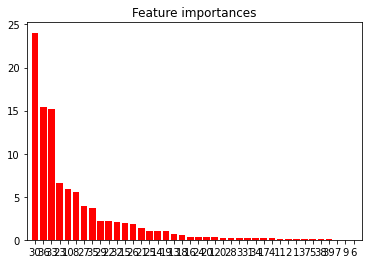

In [37]:
get_importance(cbst, cbst.get_feature_importance())

In [38]:
X_train.shape

(80251, 40)

## Тут Light auto ml


In [39]:
data = snapschot.drop(["IsUp30", "IsUp60", "Difference1", "Difference30", "Difference60",
                "FutureVWAP1", "FutureVWAP30", "FutureVWAP60"], axis=1)
data.columns
train_feat = ['BidPrice1', 'BidVolume1']
['AskPrice1', 'AskVolume1',
       'Last Trade Price', 'Last Trade Volume', 'Side', 'isNewTrade',
       'LastDealTime', 'Date', 'SMA5', 'SMA10', 'SMA30', 'SMA50',
       'SMA100', 'EMA5', 'EMA10', 'EMA30', 'EMA100', 'STD10', 'STD50',
       'STD100', 'STD1000', 'RSI14', 'RSI50', 'RSI100', 'RSI300', 'VWAP1',
       'VWAP30', 'VWAP60', 'TOP1', 'TOP30', 'TOP60', 'MIN1', 'MIN30', 'MIN60',
       'LiquidityBid', 'LiquidityAsk', 'BidLiquidityRatio']
train = {'data': data[train_feat].values,
        'target': data["IsUp1"].values}

In [40]:
train

{'data': array([[  72.5 ,  150.  ],
        [  72.52,  440.  ],
        [  72.52,  440.  ],
        ...,
        [  69.89, 1980.  ],
        [  69.89, 1980.  ],
        [  69.89, 1980.  ]]),
 'target': array([-1., -1., -1., ...,  0.,  0.,  0.])}

In [41]:
cv_iter = TimeSeriesIterator(df.Time.astype('datetime64[ns]'), n_splits=10, sorted_kfold=False)

task = Task('multiclass', )

automl = TabularAutoML(task=task, timeout=200, memory_limit=8)
oof_pred = automl.fit_predict(train, train_features=train_feat, roles={'target': "IsUp1"}, cv_iter=cv_iter)
# prediction can be made on file by
test = data[train_feat]
test.to_csv('temp_test_data.csv', index=False)
test_pred = automl.predict('temp_test_data.csv', batch_size=100, n_jobs=1)

print('Check scores...')
oof_prediction = oof_pred.data[:, 0]
not_empty = np.logical_not(np.isnan(oof_prediction))
print('OOF score: {}'.format(f1_score(train['target'][not_empty], oof_prediction[not_empty], average='micro')))
print('TEST score: {}'.format(f1_score(test['TARGET'].values, test_pred.data[:, 0], average='micro')))

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start automl preset with listed constraints:
- time: 200 seconds
- cpus: 4 cores
- memory: 8 gb

Train data shape: (107001, 3)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 192.71690392494202 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = -1.0655620888460462
Linear model: C = 5e-05 score = -0.9684501189146644
Linear model: C = 0.0001 score = -0.9276572778820992
Linear model: C = 0.0005 score = -0.8757959211596819
Linear model: C = 0.001 score = -0.8684415237701315
Linear model: C = 0.005 score = -0.8628611229327029
Linear model: C = 0.01 score = -0.8621837861439057
Linear model: C = 0.05 score = -0.8605898750855404
Linear model: C = 0.1 score = -0.8605898750855404
Linear model: C = 0.5 score = -0.8605898750855404
Linear model: C = 1e-05 score = -1.0298204434642169
Linear model: C = 5e-05 score = -0.9419730294614195
Linear model: C = 0.0001 score = -0.9171673970843587
Linear model: C = 0.0005 score = 

Time limit exceeded after calculating fold 6


Early stopping, best iteration is:
[99]	valid's multi_logloss: 0.886592
Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
Optuna may run 1 secs
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's multi_logloss: 0.902849
[200]	valid's multi_logloss: 0.907963
[300]	valid's multi_logloss: 0.932172
Early stopping, best iteration is:
[134]	valid's multi_logloss: 0.897533
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 100 rounds
[100]	valid's multi_logloss: 0.922314
Early stopping, best iteration is:
[47]	valid's multi_logloss: 0.900168
Training until validation scores don't improve for 100 rounds
[100]	valid's multi_logloss: 0.940884
Early stopping, best iteration is:
[51]	valid's multi_logloss: 0.923031
Training until validation scores don't improve for 100 rounds
[100]	valid's multi_logloss: 0.860875

100:	learn: 0.7904145	test: 0.8724404	best: 0.8724404 (100)	total: 529ms	remaining: 15.2s
200:	learn: 0.7447699	test: 0.8736891	best: 0.8712100 (125)	total: 869ms	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.871209968
bestIteration = 125

Shrink model to first 126 iterations.
Lvl_0_Pipe_1_Mod_3_CatBoost fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_3_CatBoost ...
0:	learn: 1.0837166	test: 1.0859092	best: 1.0859092 (0)	total: 4.39ms	remaining: 13.2s
100:	learn: 0.8139676	test: 0.8737457	best: 0.8737457 (100)	total: 296ms	remaining: 8.5s
200:	learn: 0.7894372	test: 0.8701287	best: 0.8691412 (161)	total: 577ms	remaining: 8.03s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8691411703
bestIteration = 161

Shrink model to first 162 iterations.
0:	learn: 1.0850434	test: 1.0864710	best: 1.0864710 (0)	total: 8.34ms	remaining: 25s
100:	learn: 0.8312567	test: 0.8930598	best: 0.8930598 (100)	total: 483ms	remaining: 1

Time limit exceeded in one of the tasks. AutoML will blend level 1 models.                                         
Try to set higher time limits or use Profiler to find bottleneck and optimize Pipelines settings


Blending: Optimization starts with equal weights and score -0.875706936397471
Blending, iter 0: score = -0.8737017585865018, weights = [0.12411318 0.         0.         0.48067734 0.39520952]
Blending, iter 1: score = -0.8736648584191208, weights = [0.16543558 0.         0.         0.33086556 0.5036989 ]
Blending, iter 2: score = -0.8736634173755128, weights = [0.17210358 0.         0.         0.29430783 0.5335886 ]
Blending, iter 3: score = -0.8736633709993216, weights = [0.17294407 0.         0.         0.28897598 0.53808   ]
Blending, iter 4: score = -0.8736633833582597, weights = [0.17279202 0.         0.         0.28902912 0.5381789 ]

Automl preset training completed in 150.68 seconds.
Check scores...


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

[0.02598676,
 0.02598676,
 0.02598676,
 0.02598676,
 0.02598676,
 0.02598676,
 0.02598676,
 0.02598676,
 0.025993884,
 0.025993884,
 0.025993884,
 0.025993884,
 0.025993884,
 0.025993884,
 0.025993884,
 0.025993884,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.027372628,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.028813703,
 0.029356126,
 0.029356126,
 0.029356126,
 0.029356126,
 0.029356126,
 0.029356126,
 0.029356126,
 0.029356126,
 0.029356126,
 0.029356126,
